# Various methods of community detection

In [1]:
import networkx as nx
from networkx.algorithms import bipartite
import string
import random
import itertools as it
import matplotlib.pyplot as plt
import numpy as np
import operator
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.drawing.nx_agraph import to_agraph 

import community
# import jgraph as igraph
import leidenalg
import igraph as ig
# import oslom

In [2]:
def ccomp(A,B):
    eds=[]
    A1=set(A.keys())
    B1=set(B.keys())
    for i in A1:
        x=set(A[i])
        for j in B1:
            y=set(B[j])
            sd=sorted(list(x.symmetric_difference(y)))
            ss=sorted(list(set(list(x)+list(y))))
            if A[i]==B[j]:
                eds.append(("louvain_comm_"+str(i),"leiden_comm_"+str(j),1.))
            else:
                if len(sd)/float(len(ss))==1:
                    eds.append(("louvain_comm_"+str(i),"leiden_comm_"+str(j),0.))
                else:
                    eds.append(("louvain_comm_"+str(i),"leiden_comm_"+str(j),len(sd)/float(len(ss))))
    H = nx.Graph()
    H.add_weighted_edges_from(eds)
    H.remove_edges_from([e for e in H.edges(data=True) if e[2]['weight']==0.])       
    return H

Nodes: 34
Edges: 78
Is connected True


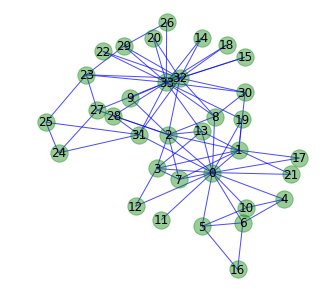

In [3]:
# n=50
# p=0.1
# G=nx.erdos_renyi_graph(n,p)

G=nx.karate_club_graph()

print "Nodes:",len(G.nodes())
print "Edges:",len(G.edges())
print "Is connected",nx.is_connected(G)

pos=graphviz_layout(G);

plt.figure(figsize=(5,5));
nodes = nx.draw_networkx_nodes(G, pos, node_color="g", alpha=0.4)
nx.draw_networkx_edges(G, pos, edge_color="b", alpha=0.7)
nx.draw_networkx_labels(G, pos)
plt.axis('off');

## 1. Louvain algorithm

{0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0, 8: 2, 9: 0, 10: 1, 11: 0, 12: 0, 13: 0, 14: 2, 15: 2, 16: 1, 17: 0, 18: 2, 19: 0, 20: 2, 21: 0, 22: 2, 23: 3, 24: 3, 25: 3, 26: 2, 27: 3, 28: 3, 29: 2, 30: 2, 31: 3, 32: 2, 33: 2}
The graph has 4 Louvain communities and modularity coefficient equal to 0.418803418803
Community 0 with 12 nodes: [0, 1, 2, 3, 7, 9, 11, 12, 13, 17, 19, 21]
Community 1 with 11 nodes: [8, 14, 15, 18, 20, 22, 26, 29, 30, 32, 33]
Community 2 with 6 nodes: [23, 24, 25, 27, 28, 31]
Community 3 with 5 nodes: [4, 5, 6, 10, 16]


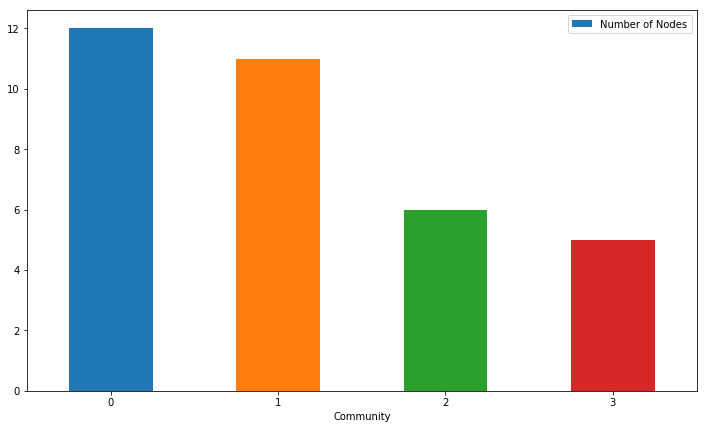

In [4]:
partition = community.best_partition(G)
print partition

kk=len(set(partition.values()))
modularity=community.modularity(partition, G, weight='weight')
print 'The graph has', kk, 'Louvain communities and modularity coefficient equal to', modularity

cml=[]
for j in range(kk):
    cj=[]
    for k,v in partition.items():
        if v==j:
            cj.append(k)
    cml.append(cj)
cmd={}
for j in range(kk):
    cmd[tuple(cml[j])]=len(cml[j])
cmd
ocmd=sorted(cmd.iteritems(), key=operator.itemgetter(1), reverse=True)
eocmd=enumerate(ocmd)
commsd={}
louvain_comm_membership={}
for i in eocmd:
    print 'Community', i[0], 'with', i[1][1], 'nodes:', list(i[1][0])
    commsd[i[0]]=i[1][1] 
    ts=list(i[1][0])
    louvain_comm_membership[i[0]]=ts 
    
ddf=pd.DataFrame(commsd.items(), columns=['Community', 'Number of Nodes'])
ddf.plot.bar(x='Community', y='Number of Nodes', figsize=(12,7),rot=0);

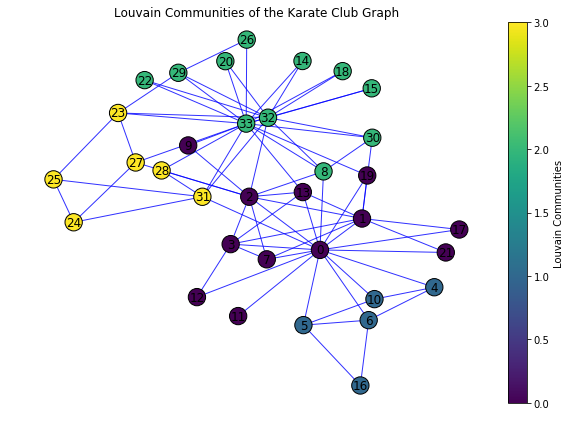

In [5]:
node_color=partition.values()
# [partition[n] for n in G.nodes()]
# range(len(G.nodes())) #[d[n] for n in G.nodes()]
vmin = min(node_color) #df['color'].min()
vmax = max(node_color) #df['color'].max()
cmap=plt.cm.viridis #plt.cm.coolwarm #plt.cm.Blues #

plt.figure(figsize=(10,7));
# pos = nx.spring_layout(G, iterations=1000) #graphviz_layout(G)
node_border_color='k'
nodes = nx.draw_networkx_nodes(G, pos, node_color=node_color, cmap=cmap, vmin=vmin, vmax=vmax)
nodes.set_edgecolor(node_border_color)
nx.draw_networkx_edges(G, pos,edge_color='b',alpha=0.8)
plt.axis('off');
yoffset = {}
y_off = -0.05  # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(G, yoffset);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,label="Louvain Communities") #, orientation='horizontal')
plt.title("Louvain Communities of the Karate Club Graph");

## 2. Leiden algorithm

The graph has 4 Louvain communities and modularity coefficient equal to 0.418803418803
Community 0 with 12 nodes: [8, 9, 14, 15, 18, 20, 22, 26, 29, 30, 32, 33]
Community 1 with 11 nodes: [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]
Community 2 with 6 nodes: [23, 24, 25, 27, 28, 31]
Community 3 with 5 nodes: [4, 5, 6, 10, 16]


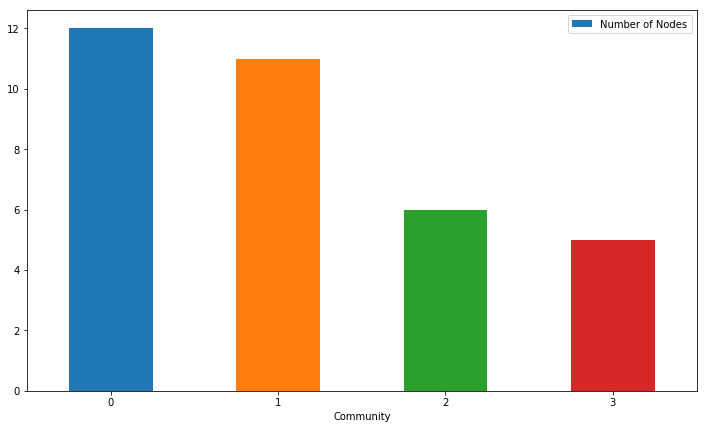

In [6]:
g = ig.Graph(directed=False)
g.add_vertices(G.nodes())
g.add_edges(G.edges())

partition = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition);
# partition = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition, weights=’weight’);

kk=len(list(partition))
partd={}
for i,j in list(enumerate(cml)):
    for jj in j:
        partd[jj]=i
modularity=community.modularity(partd, G, weight='weight')
print 'The graph has', kk, 'Louvain communities and modularity coefficient equal to', modularity

cml=list(partition)
cmd={}
for j in range(kk):
    cmd[tuple(cml[j])]=len(cml[j])
cmd
ocmd=sorted(cmd.iteritems(), key=operator.itemgetter(1), reverse=True)
eocmd=enumerate(ocmd)
commsd={}
leiden_comm_membership={}
for i in eocmd:
    print 'Community', i[0], 'with', i[1][1], 'nodes:', list(i[1][0])
    commsd[i[0]]=i[1][1] 
    ts=list(i[1][0])
    leiden_comm_membership[i[0]]=ts 
    
ddf=pd.DataFrame(commsd.items(), columns=['Community', 'Number of Nodes'])
ddf.plot.bar(x='Community', y='Number of Nodes', figsize=(12,7),rot=0);

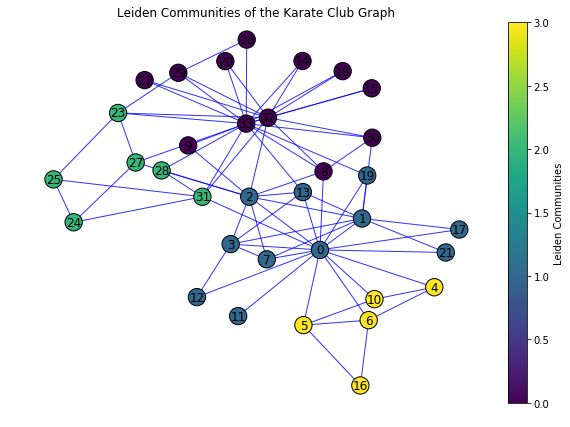

In [7]:
partd={}
for i,j in list(enumerate(cml)):
    for jj in j:
        partd[jj]=i

node_color=partd.values()
# [partition[n] for n in G.nodes()]
# range(len(G.nodes())) #[d[n] for n in G.nodes()]
vmin = min(node_color) #df['color'].min()
vmax = max(node_color) #df['color'].max()
cmap=plt.cm.viridis #plt.cm.coolwarm #plt.cm.Blues #

plt.figure(figsize=(10,7));
# pos = nx.spring_layout(G, iterations=1000) #graphviz_layout(G)
node_border_color='k'
nodes = nx.draw_networkx_nodes(G, pos, node_color=node_color, cmap=cmap, vmin=vmin, vmax=vmax)
nodes.set_edgecolor(node_border_color)
nx.draw_networkx_edges(G, pos,edge_color='b',alpha=0.8)
plt.axis('off');
yoffset = {}
y_off = -0.05  # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(G, yoffset);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,label="Leiden Communities") #, orientation='horizontal')
plt.title("Leiden Communities of the Karate Club Graph");

### Comparison/Similarities of Louvain-Leiden Communities

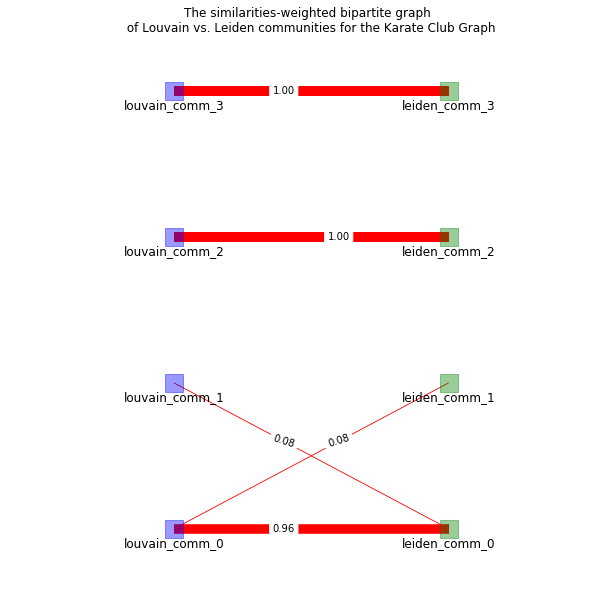

In [8]:
H=ccomp(louvain_comm_membership,leiden_comm_membership)

posbp={}
louvain=sorted([n for n in H.nodes() if "louvain" in n])
leiden=sorted([n for n in H.nodes() if "leiden" in n])
for n in H.nodes():
    for i,j in list(enumerate(louvain)):
        posbp[j]=(0,i)
    for i,j in list(enumerate(leiden)):
        posbp[j]=(1,i)
elabels={}
elabels = nx.get_edge_attributes(H,'weight')
elabelsc={}
for k,v in elabels.items():
    elabelsc[k]='%.02f' %v 
elabels=elabelsc
edge_width=[e[2]['weight'] for e in H.edges(data=True)]
edge_width=[10*w for w in edge_width]
plt.figure(figsize=(10,10));
nodes1 = nx.draw_networkx_nodes(H, posbp, nodelist=louvain,node_color="b",node_shape='s',alpha=0.4)
nodes2 = nx.draw_networkx_nodes(H, posbp, nodelist=leiden,node_color="g",node_shape='s',alpha=0.4)
nx.draw_networkx_edges(H, posbp, edge_color="r",width=edge_width, alpha=1.)
# nx.draw_networkx_labels(H, posbp)
nx.draw_networkx_edge_labels(H,posbp,edge_labels=elabels,label_pos = 0.4);
plt.axis('off');
yoffset = {}
y_off = -0.1  # offset on the y axis
for k, v in posbp.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(H, yoffset);
plt.margins(x=0.5, y=0.1)
plt.title("The similarities-weighted bipartite graph \n of Louvain vs. Leiden communities for the Karate Club Graph");

In [9]:
sim1=[]
sim2=[]
sim3=[]
for e in H.edges(data=True):
    if e[2]['weight']==1:
        sim1.append(e)
    if e[2]['weight']<1 and e[2]['weight']>=0.5:
        sim2.append(e)
    if e[2]['weight']<0.5 and e[2]['weight']>0:
        sim3.append(e)
print "There are %i pairs of completely similar communities" %len(sim1)
print "There are %i pairs of communities having percentage of identical nodes >=50%% and <100%%" %len(sim2)
print "There are %i pairs of communities having percentage of identical nodes <50%% and >0%%" %len(sim3)
r=len(louvain_comm_membership)*len(leiden_comm_membership)-len(sim1)-len(sim2)-len(sim3)
print "There are %i pairs of completely dissimilar communities" %r

There are 2 pairs of completely similar communities
There are 1 pairs of communities having percentage of identical nodes >=50% and <100%
There are 2 pairs of communities having percentage of identical nodes <50% and >0%
There are 11 pairs of completely dissimilar communities


## Robotic Data

In [10]:
# df = pd.read_csv("nodes_edges.csv", dtype='unicode')
df = pd.read_csv("/Volumes/2 TB Seagate Bac/Data_etc/nodes_edges.csv", dtype='unicode')
print "Number of rows =", len(df)
df.head(10)

Number of rows = 419986


,Node1,Node2,Weight
0,0,1,425
1,0,2,385
2,0,3,364
3,0,4,331
4,0,5,315
5,0,6,320
6,0,7,316
7,0,8,306
8,0,9,296
9,0,10,307


In [11]:
# import time
# start = time.clock()

# eds=[]
# for i in range(len(df)):
#     a=df.iloc[i]["Node1"]
#     b=df.iloc[i]["Node2"]
#     c=df.iloc[i]["Weight"]
#     eds.append((int(a),int(b),int(c)))
# print len(eds)

# G = nx.Graph()
# G.add_weighted_edges_from(eds)
# G.remove_edges_from([e for e in G.edges(data=True) if e[2]['weight']==0])

# n=len(G.nodes())
# m=len(G.edges())
# print "The graph of robotic data has %i nodes and %i edges" %(n,m) 
# if n*(n-1)/2.==float(m):
#     print "This graph is complete"
# else:
#     print "This graph is not complete"
#     if nx.is_connected(G)==True:
#         print "This graph is connected"
#     else:
#         print "This is not connected and the number of connected components =", nx.number_connected_components(G)

# nx.write_gpickle(G, "robot.gpickle")
        
# print "computed in",time.clock() - start #4.62 mins

In [12]:
G0 = nx.read_gpickle("robot.gpickle")

gedges=G0.edges(data=True)
n=len(G0.nodes())
m=len(G0.edges())
giant = max(nx.connected_component_subgraphs(G0), key=len)
print "The graph of robotic data has %i nodes and %i edges" %(n,m) 
if n*(n-1)/2.==float(m):
    print "This graph is complete"
else:
    print "This graph is not complete"
    if nx.is_connected(G0)==True:
        print "This graph is connected"
    else:
        print "This is not connected and the number of connected components =", nx.number_connected_components(G0)
        print "The giant conected component of this graph has %i nodes and %i edges" %(len(giant.nodes()),len(giant.edges()))

The graph of robotic data has 917 nodes and 409965 edges
This graph is not complete
This is not connected and the number of connected components = 12
The giant conected component of this graph has 906 nodes and 409965 edges


In [13]:
# giant = max(nx.connected_component_subgraphs(G), key=len)
# nx.write_gpickle(giant, "robotgiant.gpickle")
# giant = nx.read_gpickle("robotgiant.gpickle")
# print "Giant connected component", len(giant.nodes()),len(giant.edges())

## Louvain communities of robotic data

The graph has 20 Louvain communities and modularity coefficient equal to 0.00133023694135
Community 0 with 173 nodes: [57, 65, 66, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 495, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 576, 584, 585]
Community 1 with 12

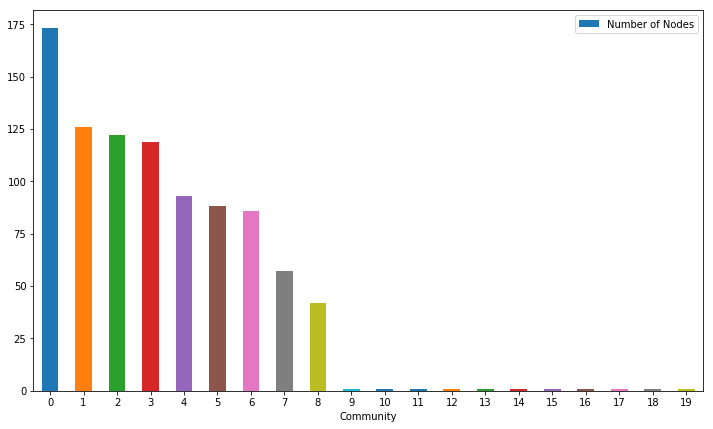

In [14]:
G=G0

partition = community.best_partition(G)

kk=len(set(partition.values()))

modularity=community.modularity(partition, G, weight='weight')
print 'The graph has', kk, 'Louvain communities and modularity coefficient equal to', modularity
cml=[]
for j in range(kk):
    cj=[]
    for k,v in partition.items():
        if v==j:
            cj.append(k)
    cml.append(cj)
cmd={}
for j in range(kk):
    cmd[tuple(cml[j])]=len(cml[j])
cmd
ocmd=sorted(cmd.iteritems(), key=operator.itemgetter(1), reverse=True)
eocmd=enumerate(ocmd)
commsd={}
louvain_comm_membership={}
for i in eocmd:
    print 'Community', i[0], 'with', i[1][1], 'nodes:', list(i[1][0])
    commsd[i[0]]=i[1][1] 
    ts=list(i[1][0])
    louvain_comm_membership[i[0]]=ts
    
ddf=pd.DataFrame(commsd.items(), columns=['Community', 'Number of Nodes'])
ddf.plot.bar(x='Community', y='Number of Nodes', figsize=(12,7),rot=0);

## Leiden communities of robotic data

The graph has 21 Louvain communities and modularity coefficient equal to 0.00136224379991
Community 0 with 342 nodes: [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 

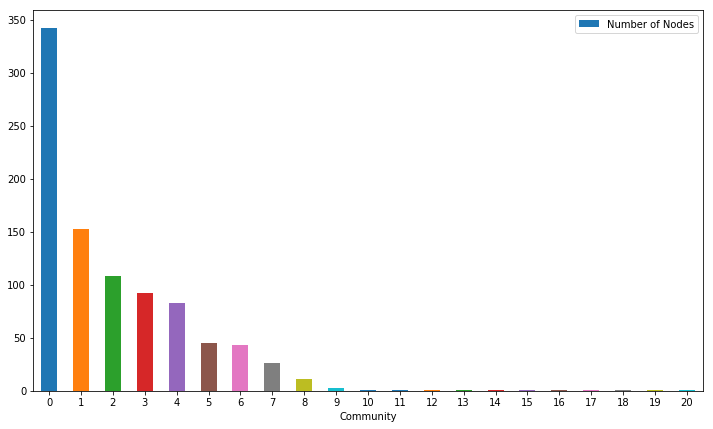

In [15]:
G=G0

g = ig.Graph(directed=False)

nodelist = list(G.nodes())
nodelist.sort()
g.add_vertices(G.nodes())
g.add_edges(G.edges())
g.es["weight"]=[e[2]['weight'] for e in G.edges(data=True)]

# mapping = {old_label:new_label for new_label, old_label in enumerate(G.nodes())}
# H = nx.relabel_nodes(G, mapping)
# g.add_vertices(H.nodes())
# g.add_edges(H.edges())

# partition = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition);
partition = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition, weights='weight');

# mpart=[]
# for i in list(partition):
#     t=[]
#     for j in i:
#         for k,v in mapping.items():
#             if v==j:
#                 t.append(k)
#     mpart.append(t)


kk=len(list(partition))

cml=list(partition)
partd={}
for i,j in list(enumerate(cml)):
    for jj in j:
        partd[jj]=i
modularity=community.modularity(partd, G, weight='weight')
print 'The graph has', kk, 'Louvain communities and modularity coefficient equal to', modularity


# cml=mpart

cmd={}
for j in range(kk):
    cmd[tuple(cml[j])]=len(cml[j])
cmd
ocmd=sorted(cmd.iteritems(), key=operator.itemgetter(1), reverse=True)
eocmd=enumerate(ocmd)
commsd={}
leiden_comm_membership={}
for i in eocmd:
    print 'Community', i[0], 'with', i[1][1], 'nodes:', list(i[1][0])
    commsd[i[0]]=i[1][1] 
    ts=list(i[1][0])
    leiden_comm_membership[i[0]]=ts
    
ddf=pd.DataFrame(commsd.items(), columns=['Community', 'Number of Nodes'])
ddf.plot.bar(x='Community', y='Number of Nodes', figsize=(12,7),rot=0);

### Comparison/Similarities of Louvain-Leiden Communities

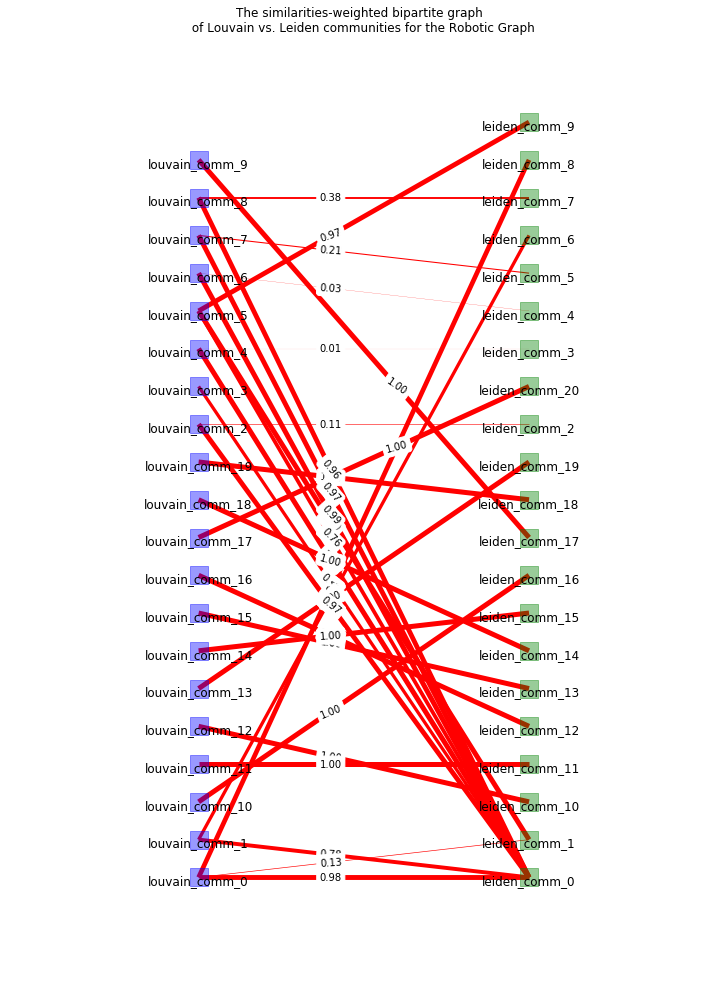

In [16]:
H=ccomp(louvain_comm_membership,leiden_comm_membership)

posbp={}
louvain=sorted([n for n in H.nodes() if "louvain" in n])
leiden=sorted([n for n in H.nodes() if "leiden" in n])
for n in H.nodes():
    for i,j in list(enumerate(louvain)):
        posbp[j]=(0,i)
    for i,j in list(enumerate(leiden)):
        posbp[j]=(1,i)
elabels={}
elabels = nx.get_edge_attributes(H,'weight')
elabelsc={}
for k,v in elabels.items():
    elabelsc[k]='%.02f' %v 
elabels=elabelsc
edge_width=[e[2]['weight'] for e in H.edges(data=True)]
edge_width=[5*w for w in edge_width]
plt.figure(figsize=(12,17));
nodes1 = nx.draw_networkx_nodes(H, posbp, nodelist=louvain,node_color="b",node_shape='s',alpha=0.4)
nodes2 = nx.draw_networkx_nodes(H, posbp, nodelist=leiden,node_color="g",node_shape='s',alpha=0.4)
nx.draw_networkx_edges(H, posbp, edge_color="r",width=edge_width, alpha=1.)
# nx.draw_networkx_labels(H, posbp)
nx.draw_networkx_edge_labels(H,posbp,edge_labels=elabels,label_pos = 0.4);
plt.axis('off');
yoffset = {}
y_off = -0.1  # offset on the y axis
for k, v in posbp.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(H, yoffset);
plt.margins(x=0.5, y=0.1)
plt.title("The similarities-weighted bipartite graph \n of Louvain vs. Leiden communities for the Robotic Graph");

In [17]:
sim1=[]
sim2=[]
sim3=[]
for e in H.edges(data=True):
    if e[2]['weight']==1:
        sim1.append(e)
    if e[2]['weight']<1 and e[2]['weight']>=0.5:
        sim2.append(e)
    if e[2]['weight']<0.5 and e[2]['weight']>0:
        sim3.append(e)
print "There are %i pairs of completely similar communities" %len(sim1)
print "There are %i pairs of communities having percentage of identical nodes >=50%% and <100%%" %len(sim2)
print "There are %i pairs of communities having percentage of identical nodes <50%% and >0%%" %len(sim3)
r=len(louvain_comm_membership)*len(leiden_comm_membership)-len(sim1)-len(sim2)-len(sim3)
print "There are %i pairs of completely dissimilar communities" %r

There are 11 pairs of completely similar communities
There are 13 pairs of communities having percentage of identical nodes >=50% and <100%
There are 6 pairs of communities having percentage of identical nodes <50% and >0%
There are 390 pairs of completely dissimilar communities


In [18]:
# sdf=df.sample(frac=0.00011)
# print "Number of sampled rows =", len(sdf)
# sdf.head(10)

In [19]:
# eds=[]
# for i in range(len(sdf)):
#     a=sdf.iloc[i]["Node1"]
#     b=sdf.iloc[i]["Node2"]
#     c=sdf.iloc[i]["Weight"]
#     eds.append((int(a),int(b),int(c)))
# len(eds)

In [20]:
# G = nx.Graph()
# G.add_weighted_edges_from(eds)

# print len(G.nodes()) #, 'nodes:', G.nodes() 
# print len(G.edges()) #, 'edges:', G.edges(data=True)
# print "Is connected",nx.is_connected(G)
# print "number of connected components =", nx.number_connected_components(G)
# giant = max(nx.connected_component_subgraphs(G), key=len)
# print "Giant connected component", len(giant.nodes()),len(giant.edges())

In [21]:
# pos=graphviz_layout(G);

# plt.figure(figsize=(5,5));
# nodes = nx.draw_networkx_nodes(G, pos, node_color="g", alpha=0.4)
# nx.draw_networkx_edges(G, pos, edge_color="b", alpha=0.7)
# nx.draw_networkx_labels(G, pos)
# plt.axis('off');

## Sampled Robotic Data

In [22]:
while True:
    sedges=random.sample(gedges,700)
    S = nx.Graph(sedges)
    giant = max(nx.connected_component_subgraphs(S), key=len)
    if nx.is_tree(giant)==False:
        if len(giant.edges())>len(giant.nodes()):  #+2:
# #     if len(giant.nodes())<100:
            break
print len(S),len(S.edges()),len(giant)
# while True:
#     sdf=df.sample(frac=0.001)
#     eds=[]
#     for i in range(len(sdf)):
#         a=sdf.iloc[i]["Node1"]
#         b=sdf.iloc[i]["Node2"]
#         c=sdf.iloc[i]["Weight"]
#         eds.append((int(a),int(b),int(c)))
#     G = nx.Graph()
#     G.add_weighted_edges_from(eds)
#     if len(G.nodes())<600:
#         pass
#     giant = max(nx.connected_component_subgraphs(G), key=len)
#     if nx.is_tree(giant)==False:
#         if len(giant.edges())>len(giant.nodes())+2:
# #     if len(giant.nodes())<100:
#             break

719 700 532


In [23]:
G=S
print "The graph of sampled robotic data has %i nodes and %i edges" %(len(G.nodes()),len(G.edges()))

if nx.is_connected(G)==True:
    print "The graph of sampled robotic data is connected"
else:
    print "The graph of sampled robotic data is not connected and the number of connected components =", nx.number_connected_components(G)

giant = max(nx.connected_component_subgraphs(G), key=len)
print "The giant connected component of the graph of sampled robotic data has %i nodes and %i edges" %(len(giant.nodes()),len(giant.edges()))
print "Is this graph a tree?",nx.is_tree(giant)

The graph of sampled robotic data has 719 nodes and 700 edges
The graph of sampled robotic data is not connected and the number of connected components = 56
The giant connected component of the graph of sampled robotic data has 532 nodes and 568 edges
Is this graph a tree? False


False


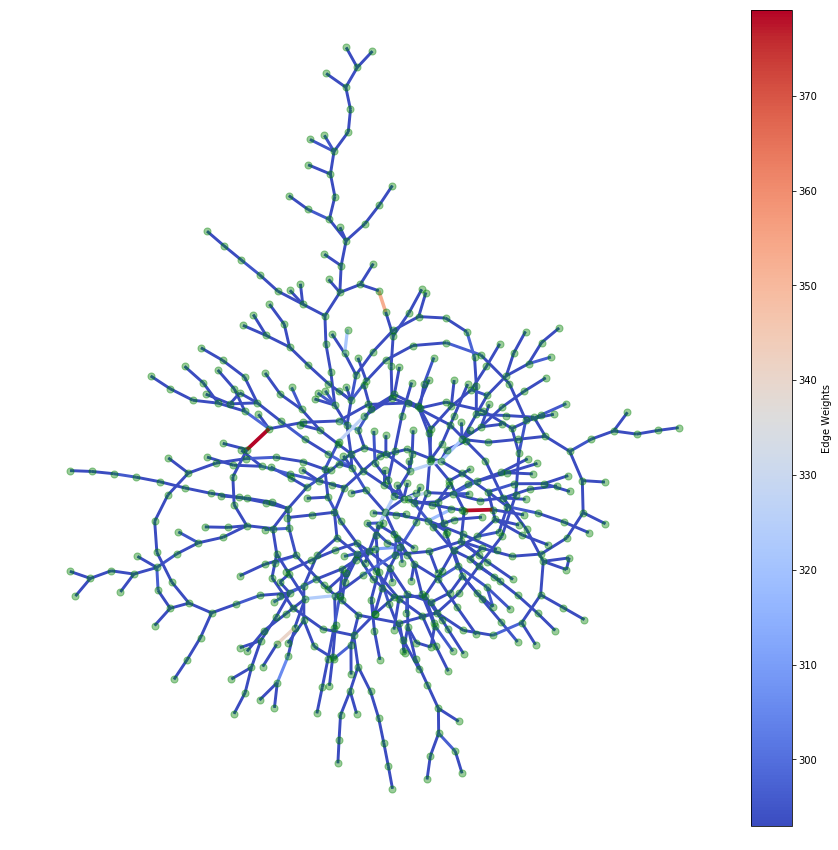

In [24]:
G=giant
print nx.is_tree(G)

elabels={}
elabels = nx.get_edge_attributes(G,'weight')

weight_list = [ e[2]['weight'] for e in G.edges(data=True) ]

cmap_e=plt.cm.coolwarm #plt.cm.tab20b 
# edge_color=weight_list
vmin_e = min(weight_list) 
vmax_e = max(weight_list) 

width_list=[0.01*w for w in weight_list]

pos=graphviz_layout(G);

plt.figure(figsize=(15,15));
nodes = nx.draw_networkx_nodes(G, pos, node_size=50,node_color="g", alpha=0.4)
nx.draw_networkx_edges(G, pos, edge_color="b", alpha=0.7)
# nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos=pos,width=width_list,edge_color=weight_list,edge_cmap=cmap_e,vmin=vmin_e, vmax=vmax_e,alpha=1.)
# nx.draw_networkx_edge_labels(G,pos,edge_labels=elabels); #,label_pos = 0.6);
plt.axis('off');

sm_e = plt.cm.ScalarMappable(cmap=cmap_e, norm=plt.Normalize(vmin=vmin_e, vmax=vmax_e))
sm_e.set_array([])
cbar = plt.colorbar(sm_e,label='Edge Weights') #, orientation='horizontal')
# plt.margins(x=0.05, y=0.1)

The graph has 22 Louvain communities and modularity coefficient equal to 0.858771544479
Community 0 with 43 nodes: [9, 14, 19, 43, 154, 175, 177, 186, 188, 195, 262, 318, 331, 391, 412, 451, 463, 469, 471, 500, 509, 512, 568, 594, 602, 619, 627, 629, 656, 710, 713, 734, 738, 740, 756, 789, 806, 861, 904, 907, 908, 910, 915]
Community 1 with 30 nodes: [34, 44, 55, 171, 206, 227, 250, 268, 352, 371, 404, 411, 433, 444, 544, 553, 615, 635, 640, 651, 686, 718, 725, 759, 763, 770, 778, 787, 816, 903]
Community 2 with 29 nodes: [6, 12, 73, 86, 94, 116, 128, 142, 161, 180, 303, 323, 359, 430, 434, 488, 527, 661, 703, 707, 744, 746, 785, 793, 804, 814, 843, 874, 884]
Community 3 with 27 nodes: [28, 71, 91, 103, 118, 125, 135, 207, 216, 240, 291, 317, 375, 402, 417, 424, 457, 489, 498, 543, 604, 632, 788, 828, 837, 886, 899]
Community 4 with 27 nodes: [13, 24, 33, 61, 124, 144, 155, 164, 239, 358, 362, 372, 437, 497, 503, 505, 700, 702, 728, 755, 776, 779, 832, 842, 889, 909, 912]
Community 5 w

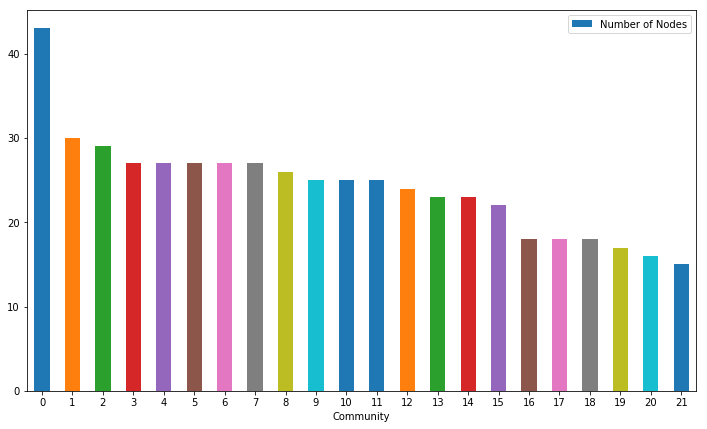

In [25]:
partition = community.best_partition(G)

kk=len(set(partition.values()))
modularity=community.modularity(partition, G, weight='weight')
print 'The graph has', kk, 'Louvain communities and modularity coefficient equal to', modularity
# print 'The graph has', kk, 'Louvain communities'
cml=[]
for j in range(kk):
    cj=[]
    for k,v in partition.items():
        if v==j:
            cj.append(k)
    cml.append(cj)
cmd={}
for j in range(kk):
    cmd[tuple(cml[j])]=len(cml[j])
cmd
ocmd=sorted(cmd.iteritems(), key=operator.itemgetter(1), reverse=True)
eocmd=enumerate(ocmd)
commsd={}
louvain_comm_membership={}
for i in eocmd:
    print 'Community', i[0], 'with', i[1][1], 'nodes:', list(i[1][0])
    commsd[i[0]]=i[1][1] 
    ts=list(i[1][0])
    louvain_comm_membership[i[0]]=ts 
    
ddf=pd.DataFrame(commsd.items(), columns=['Community', 'Number of Nodes'])
ddf.plot.bar(x='Community', y='Number of Nodes', figsize=(12,7),rot=0);

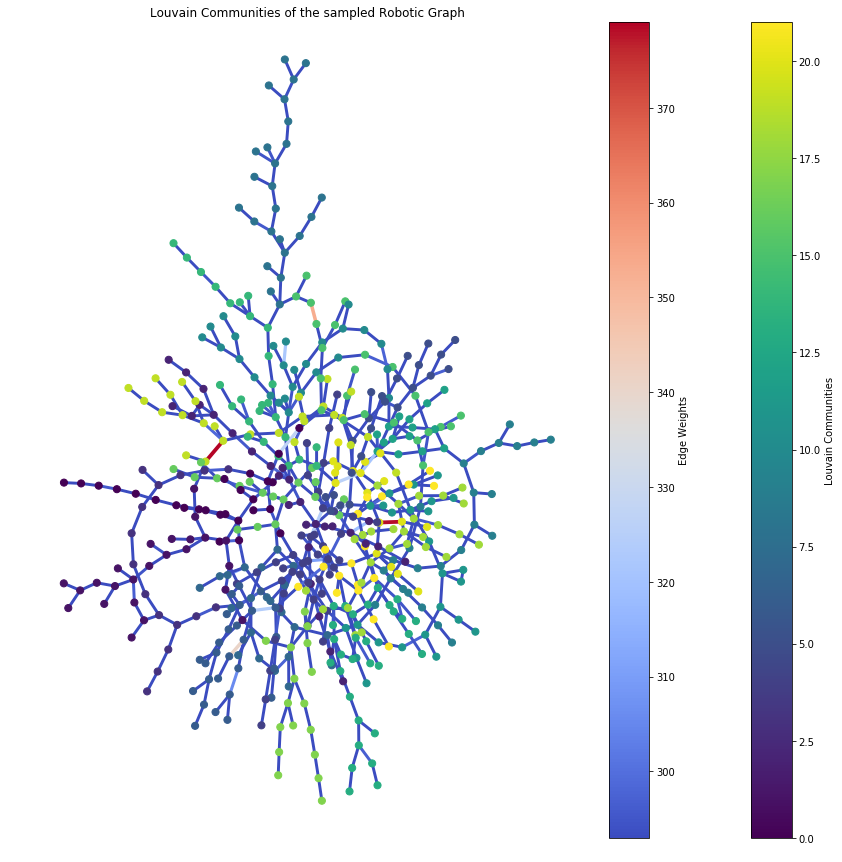

In [26]:
node_color=partition.values()
# [partition[n] for n in G.nodes()]
# range(len(G.nodes())) #[d[n] for n in G.nodes()]
vmin = min(node_color) #df['color'].min()
vmax = max(node_color) #df['color'].max()
cmap=plt.cm.viridis #plt.cm.coolwarm #plt.cm.Blues #

# edge_color=weight_list
# vmin_n = min(edge_color) #df['color'].min()
# vmax_n = max(edge_color) #df['color'].max()
# cmap_n=plt.cm.coolwarm #plt.cm.Blues #

plt.figure(figsize=(15,15));

nodes = nx.draw_networkx_nodes(G, pos, node_size=50,node_color=node_color, cmap=cmap, vmin=vmin, vmax=vmax)
nx.draw_networkx_edges(G, pos, edge_color="b", alpha=0.7)
# nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos=pos,width=width_list,edge_color=weight_list,edge_cmap=cmap_e,vmin=vmin_e, vmax=vmax_e,alpha=1.)
# nx.draw_networkx_edge_labels(G,pos,edge_labels=elabels); #,label_pos = 0.6);

plt.axis('off');
# yoffset = {}
# y_off = -0.08  # offset on the y axis
# for k, v in pos.items():
#     yoffset[k] = (v[0], v[1]+y_off)
# nx.draw_networkx_labels(G, yoffset);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,label="Louvain Communities") #, orientation='horizontal')

sm_e = plt.cm.ScalarMappable(cmap=cmap_e, norm=plt.Normalize(vmin=vmin_e, vmax=vmax_e))
sm_e.set_array([])
cbar = plt.colorbar(sm_e,label='Edge Weights') #, orientation='horizontal')
# plt.margins(x=0.05, y=0.1)
plt.title("Louvain Communities of the sampled Robotic Graph");

The graph has 23 Louvain communities and modularity coefficient equal to 0.858771544479
Community 0 with 39 nodes: [10, 28, 33, 54, 64, 67, 69, 75, 96, 98, 106, 113, 142, 163, 175, 179, 197, 234, 239, 288, 308, 310, 323, 329, 331, 345, 348, 353, 367, 368, 436, 448, 458, 476, 489, 492, 495, 517, 522]
Community 1 with 38 nodes: [18, 24, 30, 97, 118, 132, 136, 147, 157, 196, 203, 216, 230, 233, 249, 256, 302, 314, 320, 359, 363, 374, 377, 383, 389, 395, 412, 413, 416, 438, 440, 444, 445, 451, 456, 460, 474, 521]
Community 2 with 27 nodes: [14, 36, 40, 50, 66, 71, 77, 89, 119, 125, 139, 159, 168, 182, 218, 229, 243, 261, 282, 313, 351, 371, 457, 482, 490, 512, 519]
Community 3 with 26 nodes: [4, 8, 9, 23, 84, 100, 107, 183, 189, 224, 259, 264, 268, 270, 295, 296, 349, 362, 385, 408, 421, 424, 503, 524, 525, 527]
Community 4 with 26 nodes: [22, 26, 43, 79, 123, 133, 146, 149, 172, 198, 200, 213, 245, 255, 265, 279, 291, 294, 326, 388, 428, 441, 443, 447, 463, 472]
Community 5 with 26 nodes:

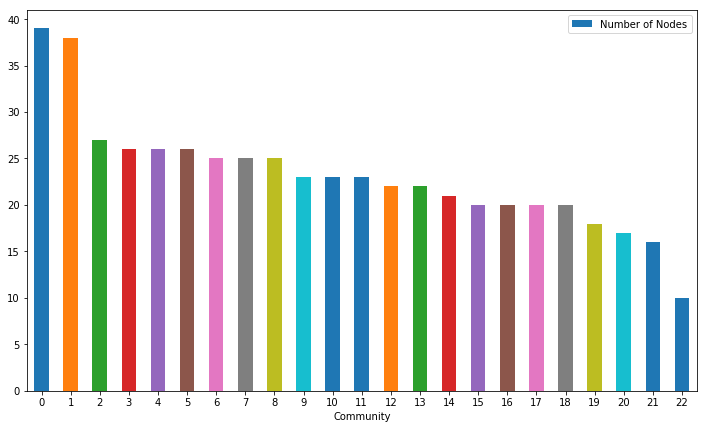

In [27]:
g = ig.Graph(directed=False)

nodelist = list(G.nodes())
nodelist.sort()
mapping = {old_label:new_label for new_label, old_label in enumerate(G.nodes())}
H = nx.relabel_nodes(G, mapping)

g.add_vertices(H.nodes())
g.add_edges(H.edges())
g.es["weight"]=[e[2]['weight'] for e in H.edges(data=True)]

# partition = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition);
partition = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition, weights='weight');

mpart=[]
for i in list(partition):
    t=[]
    for j in i:
        for k,v in mapping.items():
            if v==j:
                t.append(k)
    mpart.append(t)

kk=len(list(partition))

cml=list(partition)
partd={}
for i,j in list(enumerate(cml)):
    for jj in j:
        partd[jj]=i
# modularity=community.modularity(partd, H, weight='weight')
print 'The graph has', kk, 'Louvain communities and modularity coefficient equal to', modularity


# # cml=mpart
# kk=len(list(partition))
# print 'The graph has', kk, 'Leiden communities'
# cml=mpart

cmd={}
for j in range(kk):
    cmd[tuple(cml[j])]=len(cml[j])
cmd
ocmd=sorted(cmd.iteritems(), key=operator.itemgetter(1), reverse=True)
eocmd=enumerate(ocmd)
commsd={}
leiden_comm_membership={}
for i in eocmd:
    print 'Community', i[0], 'with', i[1][1], 'nodes:', list(i[1][0])
    commsd[i[0]]=i[1][1] 
    ts=list(i[1][0])
    leiden_comm_membership[i[0]]=ts 
    
ddf=pd.DataFrame(commsd.items(), columns=['Community', 'Number of Nodes'])
ddf.plot.bar(x='Community', y='Number of Nodes', figsize=(12,7),rot=0);

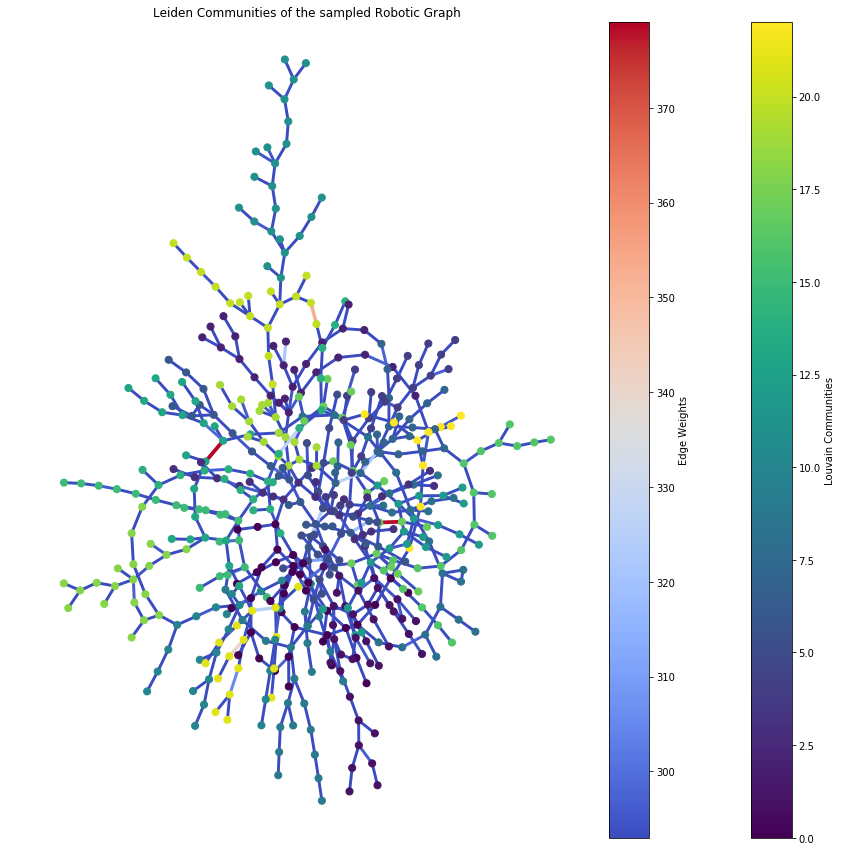

In [28]:
partd={}
for i,j in list(enumerate(cml)):
    for jj in j:
        partd[jj]=i
        
node_color=partd.values()
# [partition[n] for n in G.nodes()]
# range(len(G.nodes())) #[d[n] for n in G.nodes()]
vmin = min(node_color) #df['color'].min()
vmax = max(node_color) #df['color'].max()
cmap=plt.cm.viridis #plt.cm.coolwarm #plt.cm.Blues #

# edge_color=weight_list
# vmin_n = min(edge_color) #df['color'].min()
# vmax_n = max(edge_color) #df['color'].max()
# cmap_n=plt.cm.coolwarm #plt.cm.Blues #

plt.figure(figsize=(15,15));

nodes = nx.draw_networkx_nodes(G, pos, node_size=50,node_color=node_color, cmap=cmap, vmin=vmin, vmax=vmax)
nx.draw_networkx_edges(G, pos, edge_color="b", alpha=0.7)
# nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos=pos,width=width_list,edge_color=weight_list,edge_cmap=cmap_e,vmin=vmin_e, vmax=vmax_e,alpha=1.)
# nx.draw_networkx_edge_labels(G,pos,edge_labels=elabels); #,label_pos = 0.6);

plt.axis('off');
# yoffset = {}
# y_off = -0.08  # offset on the y axis
# for k, v in pos.items():
#     yoffset[k] = (v[0], v[1]+y_off)
# nx.draw_networkx_labels(G, yoffset);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm,label="Louvain Communities") #, orientation='horizontal')

sm_e = plt.cm.ScalarMappable(cmap=cmap_e, norm=plt.Normalize(vmin=vmin_e, vmax=vmax_e))
sm_e.set_array([])
cbar = plt.colorbar(sm_e,label='Edge Weights') #, orientation='horizontal')
# plt.margins(x=0.05, y=0.1)
plt.title("Leiden Communities of the sampled Robotic Graph");

### Comparison/Similarities of Louvain-Leiden Communities

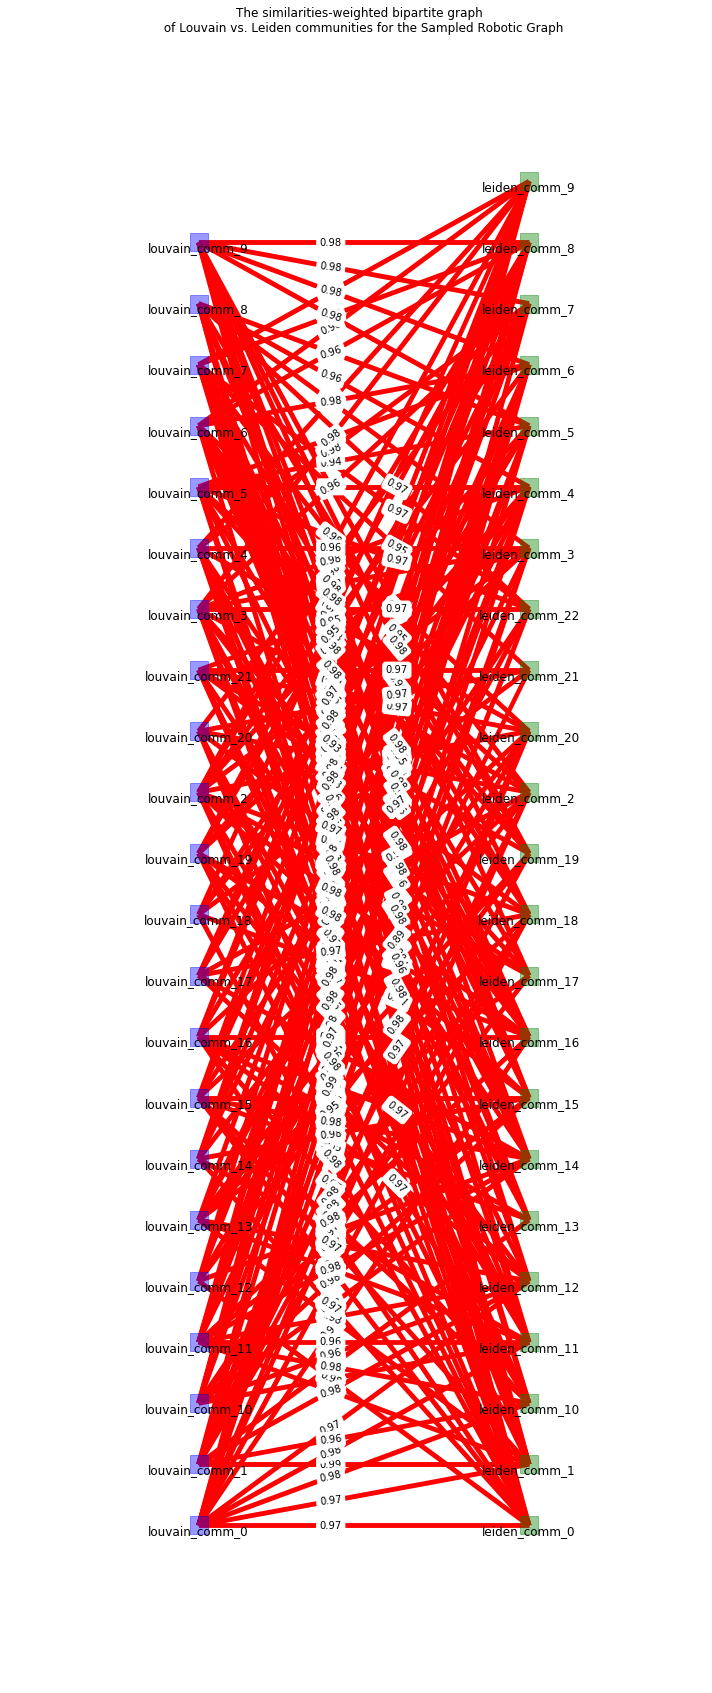

In [29]:
H=ccomp(louvain_comm_membership,leiden_comm_membership)

posbp={}
louvain=sorted([n for n in H.nodes() if "louvain" in n])
leiden=sorted([n for n in H.nodes() if "leiden" in n])
for n in H.nodes():
    for i,j in list(enumerate(louvain)):
        posbp[j]=(0,i)
    for i,j in list(enumerate(leiden)):
        posbp[j]=(1,i)
elabels={}
elabels = nx.get_edge_attributes(H,'weight')
elabelsc={}
for k,v in elabels.items():
    elabelsc[k]='%.02f' %v 
elabels=elabelsc
edge_width=[e[2]['weight'] for e in H.edges(data=True)]
edge_width=[5*w for w in edge_width]
plt.figure(figsize=(12,30));
nodes1 = nx.draw_networkx_nodes(H, posbp, nodelist=louvain,node_color="b",node_shape='s',alpha=0.4)
nodes2 = nx.draw_networkx_nodes(H, posbp, nodelist=leiden,node_color="g",node_shape='s',alpha=0.4)
nx.draw_networkx_edges(H, posbp, edge_color="r",width=edge_width, alpha=1.)
# nx.draw_networkx_labels(H, posbp)
nx.draw_networkx_edge_labels(H,posbp,edge_labels=elabels,label_pos = 0.4);
plt.axis('off');
yoffset = {}
y_off = -0.1  # offset on the y axis
for k, v in posbp.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(H, yoffset);
plt.margins(x=0.5, y=0.1)
plt.title("The similarities-weighted bipartite graph \n of Louvain vs. Leiden communities for the Sampled Robotic Graph");

In [30]:
sim1=[]
sim2=[]
sim3=[]
for e in H.edges(data=True):
    if e[2]['weight']==1:
        sim1.append(e)
    if e[2]['weight']<1 and e[2]['weight']>=0.5:
        sim2.append(e)
    if e[2]['weight']<0.5 and e[2]['weight']>0:
        sim3.append(e)
print "There are %i pairs of completely similar communities" %len(sim1)
print "There are %i pairs of communities having percentage of identical nodes >=50%% and <100%%" %len(sim2)
print "There are %i pairs of communities having percentage of identical nodes <50%% and >0%%" %len(sim3)
r=len(louvain_comm_membership)*len(leiden_comm_membership)-len(sim1)-len(sim2)-len(sim3)
print "There are %i pairs of completely dissimilar communities" %r

There are 0 pairs of completely similar communities
There are 225 pairs of communities having percentage of identical nodes >=50% and <100%
There are 0 pairs of communities having percentage of identical nodes <50% and >0%
There are 281 pairs of completely dissimilar communities
